## Auditing the COMPAS Score: Predictive Modeling and Algorithmic Fairness

We will be using the dataset at [https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv](https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv). Reading it in:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn import preprocessing
import learningmachine as lm

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(0)

In [3]:
# read in data as Pandas dataframe
df_in = pd.read_csv("https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv")

In [4]:
df_in.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In preparation for upcoming analysis, we'll also change categorical variables (`sex` and `c_charge_degree`) to numerical labels. 

In [5]:
lm.label_encode(df_in, 'sex')
lm.label_encode(df_in, 'c_charge_degree')

Convert Pandas dataframe to list of lists.

In [6]:
compas = lm.df_to_list(df_in)

In [7]:
# inspect amount of data (number of defendants)
len(compas)

7214

First, we'll split our data into train, validation, and test sets using a 70:15:15 split ratio.

In [8]:
idx = list(range(len(compas)))
np.random.shuffle(idx)

train_size = int(.7*len(compas))
valid_size = int(.15*len(compas)) 
test_size = int(.15*len(compas))

compas_train = [compas[i] for i in idx[:train_size]]
compas_valid = [compas[i] for i in idx[train_size+1:train_size+valid_size]]
compas_test = [compas[i] for i in idx[train_size+valid_size+1:train_size+valid_size+test_size+1]]

**PART 1: COMPARING THE SCORES OF BLACK AND WHITE DEFENDANTS**

We first explore if white and black defendants get the same COMPAS scores.

In [9]:
# data for black defendants
compas_train_b = [row for row in compas_train if 'African-American' in row]
compas_valid_b = [row for row in compas_valid if 'African-American' in row]

# data for white defendants
compas_train_w = [row for row in compas_train if 'Caucasian' in row]
compas_valid_w = [row for row in compas_valid if 'Caucasian' in row]

Since our lists no longer contain column names, use a function in the `learningmachine` module that will allow us to index into our list using the original column names.

In [10]:
index_feature_list = lm.columnname_to_index(df_in)

In [11]:
def feature_ind(feat_name):
    """
    Take feature name and return relevant index within list.
    """
    for row in index_feature_list:
        if feat_name == row[1]:
            return row[0]

In [12]:
# list of decile scores for black defendants in training data
decile_scores_b = [x[feature_ind('decile_score')] for x in compas_train_b]

# list of decile scores for white defendants in training data
decile_scores_w = [x[feature_ind('decile_score')] for x in compas_train_w]

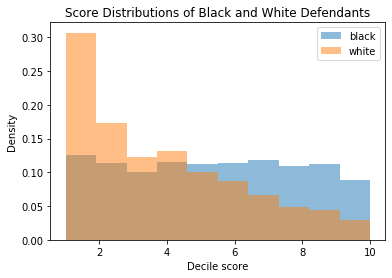

In [13]:
# overlapping histograms of decile scores of black and white defendants
plt.hist(decile_scores_b, density=True, alpha=0.5, label='black')
plt.hist(decile_scores_w, density=True, alpha=0.5, label='white')
plt.title("Score Distributions of Black and White Defendants")
plt.xlabel('Decile score')
plt.ylabel('Density')
plt.legend(loc="upper right")
plt.show()

For African-American defendants, the distribution of the scores is approximately uniform. For Caucasian defendants, many more get low scores than high scores.

**PART 2: INITIAL EVALUATION OF THE COMPAS SCORES**

Here, we are computing the false positive rate (FPR), false negative rate (FNR), and correct classification rate (CCR) for different populations. First, we'll define functions to compute the quantities needed. 

In [14]:
def getFPR(data, thr):
    """
    Return false positive rate for COMPAS data data, using
    thr as the threshold on the decile score
    
    Keyword arguments:
    data -- dataset containing data with features and outcome
    thr -- threshold 
    """
    false_positives = 0
    total_negatives = 0
    
    for row in data:
        if row[feature_ind('decile_score')] >= thr and row[feature_ind('is_recid')] == 0:
            false_positives += 1
        if row[feature_ind('is_recid')] == 0:
            total_negatives += 1
            
    return false_positives/total_negatives


def getFNR(data, thr):
    """
    Return false negative rate for COMPAS data data, using
    thr as the threshold on the decile score
    
    Keyword arguments:
    data -- dataset containing data with features and outcome
    thr -- threshold 
    """
    false_negatives = 0
    total_positives = 0
    
    for row in data:
        if row[feature_ind('decile_score')] < thr and row[feature_ind('is_recid')] == 1:
            false_negatives += 1
        if row[feature_ind('is_recid')] == 1:
            total_positives += 1 
    
    return false_negatives/total_positives


def getCCR(data, thr):
    """
    Return correct classification rate for COMPAS data data, using
    thr as the threshold on the decile score
    
    Keyword arguments:
    data -- dataset containing data with features and outcome
    thr -- threshold 
    """
    correctly_classified = 0
    
    for row in data:
        if row[feature_ind('decile_score')] >= thr and row[feature_ind('is_recid')] == 1:
            correctly_classified += 1
        if row[feature_ind('decile_score')] < thr and row[feature_ind('is_recid')] == 0:
            correctly_classified += 1
        
    return correctly_classified/len(data)

Given a threshold of 5, we can compute the scores.

In [15]:
thr = 5

fps = [getFPR(compas_valid_b, thr), getFPR(compas_valid_w, thr), getFPR(compas_valid, thr)]
fns = [getFNR(compas_valid_b, thr), getFNR(compas_valid_w, thr), getFNR(compas_valid, thr)]
ccr = [getCCR(compas_valid_b, thr), getCCR(compas_valid_w, thr), getCCR(compas_valid, thr)]

print('FPR for black, white, and all defendants:', fps)
print()
print('FNR for black, white, and all defendants:', fns)
print()
print('CCR for black, white, and all defendants:', ccr)

FPR for black, white, and all defendants: [0.38846153846153847, 0.2706422018348624, 0.3120689655172414]

FNR for black, white, and all defendants: [0.29372937293729373, 0.47058823529411764, 0.37924151696606784]

CCR for black, white, and all defendants: [0.6625222024866785, 0.652542372881356, 0.6567992599444958]


We can see that the scores do not satisfy false positive parity and do not satisfy false negative parity. The scores do satisfy classification parity. Demographic parity is also not satisfied.

**PART 3: ALTERING THE THRESHOLD**

We will now see how changing the threshold influences the false positive, false negative, and correct classification rates.

In [16]:
def getRates(data, thr):
    """
    Return list containing FPR, FNR, and CCR. 
    
    Keyword arguments:
    data -- dataset containing data with features and outcome
    thr -- threshold 
    """
    return [getFPR(data, thr), getFNR(data, thr), getCCR(data, thr)]

In [17]:
# list of thresholds
thrs = list(range(0,10,1))

# make lists of rates for white defendants, black defendants, and all defendants
rates_w = [getRates(compas_valid_w, thr) for thr in thrs]   
rates_b = [getRates(compas_valid_b, thr) for thr in thrs] 
rates_all = [getRates(compas_valid, thr) for thr in thrs]

In [18]:
def PlotRates(rates_data, thrs, title):
    """
    Plot rate (FPR, FNR, CCR) on y axis and threshold on x axis.
    
    Keyword arguments:
    rates_data -- list of previously calculated rates (FPR, FNR, CCR)
    thrs -- list of thresholds
    title -- title of figure ('white defendants', 'black defendents', or 'all defendents')
    """
    plt.plot(thrs, [x[0] for x in rates_data], label='FPR')
    plt.plot(thrs, [x[1] for x in rates_data], label='FNR')
    plt.plot(thrs, [x[2] for x in rates_data], label='CCR')
    plt.xlim(1, 9)
    plt.title(title)
    plt.xlabel('threshold')
    plt.ylabel('rate')
    plt.legend(loc="upper right")
    plt.show()

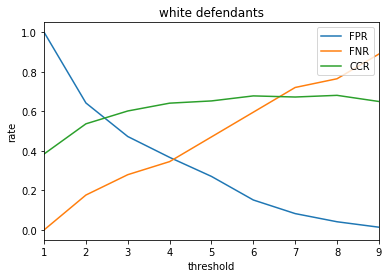

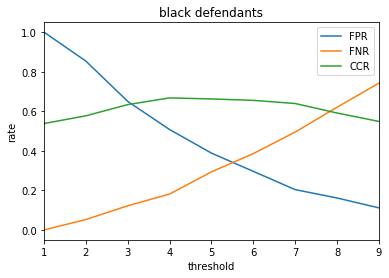

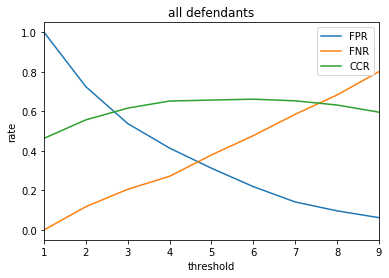

In [19]:
PlotRates(rates_w, thrs, "white defendants")
PlotRates(rates_b, thrs, "black defendants")
PlotRates(rates_all, thrs, "all defendants")

**PART 4: TRYING TO REPRODUCE THE SCORE**

Before we fit the model, let's split our datasets into predictors (x) and outcome (y). We'll build a function called `get_x_y_split` to split the data into x and y components.

In [20]:
def get_x_y_split(data, predictors):
    """
    Split data into x and y components. x will contain data corresponding to predictors of interest.
    
    Keyword arguments:
    data -- list of lists containing data 
    predictors -- list containing predictors of interest
    """    
    feats_inds = []
    x = []
    y = []

    for feat in predictors:
        feats_inds.append(feature_ind(feat))

    for defendant_data in data:
        x.append([defendant_data[i] for i in feats_inds])  
        y.append(defendant_data[feature_ind('is_recid')])
    
    return x, y

We'll create our datasets to include two predictors: `age` and `priors_count`.

In [21]:
predictors = ['age', 'priors_count']
compas_train_x, compas_train_y = get_x_y_split(compas_train, predictors)

We'll now use the `learning_machine` function to make our model.

In [22]:
my_model = lm.learning_machine(compas_train_x, compas_train_y, predictors)

We'll check out the coefficients of our model.

In [23]:
my_model.coefs

[('age', -0.048346079830393386), ('priors_count', 0.16380407311845432)]

* An increase of 1 in the number of priors is associated with an increase of 0.17 in the log-odds of recidivism, all other things being equal

* An increase in age by one year corresponds to a decrease of 0.05 in the log-odds of recidivism

* (If we are being a bit silly and extrapolate) according to the model, a newborn with no priors would have a probability of $\sigma(1.04) = 0.74$ of being re-arrested.

Let's now obtain the FPR, FNR, and CCR for our model, using the threshold  0.5.

We'll use the `predict` function to generate the model's predictions.

Now let's build our scoring functions. This time, we have the model as another parameter. 

In [24]:
def get_binary_preds(prob_preds, thr):
    """
    Return the binary versions of the predictions by 
    thresholding prob_preds with threshold thr
    """
    binary_preds = []
    for prob_pred in prob_preds:
        binary_preds.append(prob_pred > thr)
    
    return binary_preds


def getFPR_fit(model, x_data, y_data, thr):
    """
    Return the false positive rate for predictions
    by the model on x_data using threshold thr, 
    with ground truth data y_data
    
    Keyword arguments:
    model -- model generated from the learning machine
    x_data -- list of lists containing predictors 
    y_data -- list of lists containing outcome   
    thr -- threshold
    """
    prob_pred = lm.predict(model, x_data) 
    pred = get_binary_preds(prob_pred, thr)
    false_positives = 0
    total_negatives = 0
    
    for i, outcome in enumerate(y_data):
        if pred[i] == 1 and outcome == 0:
            false_positives += 1
        if outcome == 0:
            total_negatives +=1 

    return false_positives/total_negatives


def getFNR_fit(model, x_data, y_data, thr):
    """
    Return the false negative rate for predictions
    by the model on x_data using threshold thr, 
    with ground truth data y_data
    
    Keyword arguments:
    model -- model generated from the learning machine 
    x_data -- list of lists containing predictors 
    y_data -- list of lists containing outcome      
    thr -- threshold
    """
    prob_pred = lm.predict(model, x_data) 
    pred = get_binary_preds(prob_pred, thr)
    
    false_negatives = 0
    total_positives = 0
        
    for i, outcome in enumerate(y_data):
        if pred[i] == 0 and outcome == 1:
            false_negatives += 1
        if outcome == 1:
            total_positives +=1 

    return false_negatives/total_positives


def getCCR_fit(model, x_data, y_data, thr):
    """
    Return the correct classification rate rate for predictions
    by the model on x_data using threshold thr, 
    with ground truth data y_data
    
    Keyword arguments:
    model -- model generated from the learning machine  
    x_data -- list of lists containing predictors 
    y_data -- list of lists containing outcome      
    thr -- threshold
    """

    prob_pred = lm.predict(model, x_data) 
    pred = get_binary_preds(prob_pred, thr)
    
    correctly_classified = 0

    for i, outcome in enumerate(y_data):
        if pred[i] == outcome:
            correctly_classified += 1
    
    return correctly_classified/len(y_data)

In [25]:
# build relevant datasets
compas_valid_b_x, compas_valid_b_y = get_x_y_split(compas_valid_b, predictors)
compas_valid_w_x, compas_valid_w_y = get_x_y_split(compas_valid_w, predictors)
compas_valid_x, compas_valid_y = get_x_y_split(compas_valid, predictors)

In [26]:
thr = 0.5

fps_fit = [getFPR_fit(my_model, compas_valid_b_x, compas_valid_b_y, thr), getFPR_fit(my_model, compas_valid_w_x, compas_valid_w_y, thr), getFPR_fit(my_model, compas_valid_x, compas_valid_y, thr)]
fns_fit = [getFNR_fit(my_model, compas_valid_b_x, compas_valid_b_y, thr), getFNR_fit(my_model, compas_valid_w_x, compas_valid_w_y, thr), getFNR_fit(my_model, compas_valid_x, compas_valid_y, thr)]
ccr_fit = [getCCR_fit(my_model, compas_valid_b_x, compas_valid_b_y, thr), getCCR_fit(my_model, compas_valid_w_x, compas_valid_w_y, thr), getCCR_fit(my_model, compas_valid_x, compas_valid_y, thr)]

print('FPR for black, white, and all defendants:', fps_fit)
print()
print('FNR for black, white, and all defendants:', fns_fit)
print()
print('CCR for black, white, and all defendants:', ccr_fit)

FPR for black, white, and all defendants: [0.36538461538461536, 0.23853211009174313, 0.3017241379310345]

FNR for black, white, and all defendants: [0.2706270627062706, 0.4852941176470588, 0.35728542914171657]

CCR for black, white, and all defendants: [0.6856127886323268, 0.6666666666666666, 0.6725254394079556]


It appears that there is basically no overfitting. 

**PART 5: ADJUSTING THRESHOLDS**

We basically want to find the thresholds for which the false positive rates are at parity. Let's see what the rates are for different thresholds.

In [27]:
compas_train_b_x, compas_train_b_y = get_x_y_split(compas_train_b, predictors)
compas_train_w_x, compas_train_w_y = get_x_y_split(compas_train_w, predictors)

# list of thresholds
thrs = [0.3, 0.4, 0.5, 0.57, 0.6, 0.7, 0.8]

FP_b = [getFPR_fit(my_model, compas_train_b_x, compas_train_b_y, thr) for thr in thrs]
FP_w = [getFPR_fit(my_model, compas_train_w_x, compas_train_w_y, thr) for thr in thrs]

print('FPR for black defendants:', FP_b)
print()
print('FPR for white defendants:', FP_w)

FPR for black defendants: [0.8432203389830508, 0.6754237288135593, 0.36610169491525424, 0.1788135593220339, 0.14491525423728813, 0.07203389830508475, 0.03898305084745763]

FPR for white defendants: [0.6464646464646465, 0.47575757575757577, 0.2101010101010101, 0.07878787878787878, 0.06161616161616162, 0.024242424242424242, 0.010101010101010102]


In [28]:
def PlotFPR(rates_b, rates_w, thrs):
    """
    Plot rate (FPR, FNR, CCR) on y axis and threshold on x axis.
    
    Keyword arguments:
    thrs -- list of thresholds
    rates_b -- FPR list for black defendants
    rates_w -- FPR list for white defendants
    """
    plt.plot(thrs, rates_b, label="black")
    plt.plot(thrs, rates_w, label="white")
    plt.title('FPR across thresholds')
    plt.xlabel('threshold')
    plt.ylabel('FPR')
    plt.legend()

We need to tweak the threshold for black defendants just a little:

In [29]:
thrs_detail = [0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59]
FP_b_new = [getFPR_fit(my_model, compas_train_b_x, compas_train_b_y, thr) for thr in thrs_detail]

print('FPR for black defendants for tweaked thresholds:', list(zip(thrs_detail, FP_b_new)))

FPR for black defendants for tweaked thresholds: [(0.51, 0.3254237288135593), (0.52, 0.29745762711864404), (0.53, 0.2584745762711864), (0.54, 0.24067796610169492), (0.55, 0.21525423728813559), (0.56, 0.20254237288135593), (0.57, 0.1788135593220339), (0.58, 0.16779661016949152), (0.59, 0.15508474576271186)]


Let's try to visualize the threshold at which the white and black demographic would be at parity.

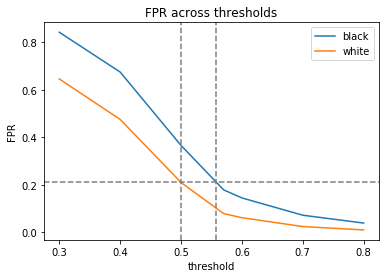

In [30]:
PlotFPR(FP_b, FP_w, thrs)
plt.axvline(x=0.5, color="grey", ls="dashed")
plt.axhline(y=0.21, color="grey", ls="dashed")
plt.axvline(x=0.557, color="grey", ls="dashed")
plt.show()

`thr = 0.557` seems about right. 

Now the white and black demographic would be at parity. We'll compute the correct classification rate on the validation set.

In [31]:
compas_valid_x, compas_valid_y = get_x_y_split(compas_valid, predictors)
getCCR_fit(my_model, compas_valid_x, compas_valid_y, 0.557)

0.669750231267345

(Note that we ignored everyone who wasn't white or black. That's OK to do, but including other demographics (in any way you like) is OK too).